In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from src.prototypes import match_flight_to_prototypes
#from src.prototypes import tune_and_label
from src.pca_k_means import analyze_flight_data_clustering

In [ ]:
#this method can be used to plot a flight path with predicted labels

def plot_flight_paths(data):
    

    for flight_id, flight_data in data.groupby("flight_id"):
        # Get min/max bounds for the dataset
        min_long, max_long = flight_data["long"].min(), flight_data["long"].max()
        min_lat, max_lat = flight_data["lat"].min(), flight_data["lat"].max()
        # Create a new figure for each flight
        plt.figure(figsize=(10, 5))

        # Plot the individual flight path with the predicted label
        plt.plot(flight_data["long"], flight_data["lat"], alpha=0.7, linewidth=1,
                 label=f"Predicted: {flight_data['label'].iloc[0]}")

        # Set labels and title for the plot
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(f"Flight Path for Flight ID: {flight_id} with Predicted Label")
        plt.grid(True)
        
        # Apply calculated bounds with padding
        plt.xlim(min_long - 0.01, max_long + 0.01)
        plt.ylim(min_lat - 0.01, max_lat + 0.01)

        # Display legend and plot
        plt.legend(loc="upper right", fontsize="small", ncol=2)
        plt.show()

#uncomment to get a grid like representation of the flight path charts
# def plot_flight_paths(data):
#     # Determine the number of unique flight IDs
#     num_flights = len(data['flight_id'].unique())
    
#     # Calculate number of rows and columns for the grid
#     ncols = 3  # You can adjust this to have more or fewer columns
#     nrows = math.ceil(num_flights / ncols)  # Calculate required rows for the grid

#     # Create a single figure for all the plots
#     fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
#     axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    
#     for i, (flight_id, flight_data) in enumerate(data.groupby("flight_id")):
#         # Get min/max bounds for the dataset
#         min_long, max_long = flight_data["long"].min(), flight_data["long"].max()
#         min_lat, max_lat = flight_data["lat"].min(), flight_data["lat"].max()

#         # Get the current axis for plotting
#         ax = axes[i]

#         # Plot the individual flight path with the predicted label
#         ax.plot(flight_data["long"], flight_data["lat"], alpha=0.7, linewidth=1,
#                 label=f"Predicted: {flight_data['label'].iloc[0]}")

#         # Set labels and title for the plot
#         ax.set_xlabel("Longitude")
#         ax.set_ylabel("Latitude")
#         ax.set_title(f"Flight Path for Flight ID: {flight_id}")

#         # Apply calculated bounds with padding
#         ax.set_xlim(min_long - 0.01, max_long + 0.01)
#         ax.set_ylim(min_lat - 0.01, max_lat + 0.01)

#         # Display legend
#         ax.legend(loc="upper right", fontsize="small", ncol=2)
#         ax.grid(True)

#      # Hide any empty subplots
#     for j in range(num_flights, len(axes)):
#         axes[j].axis('off')

#     # Adjust layout to prevent overlap
#     plt.tight_layout()
#     plt.show()

In [ ]:

#To try and get altitude close to barometric altitude, we can use the ISA model to estimate barometric altitude from geoaltitude.
#this aims to get better matching of flights to prototypes
def estimate_barometric_altitude(df, geoalt_col='geoaltitude'):
    
    # Constants from the ISA model
    P0 = 1013.25  # hPa (sea level pressure)
    L = 0.0065    # K/m (lapse rate)
    T0 = 288.15   # K (sea level temperature)
    g = 9.80665   # m/s² (gravity)
    M = 0.0289644 # kg/mol (molar mass of air)
    R = 8.31432   # J/(mol·K) (universal gas constant)

    # Compute estimated pressure at geoaltitude
    df['pressure'] = P0 * (1 - (L * df[geoalt_col]) / T0) ** ((g * M) / (R * L))

    # Compute barometric altitude
    df['baro_altitude'] = df[geoalt_col] - (T0 / L) * (1 - (df['pressure'] / P0) ** ((R * L) / g))
    
    return df




In [ ]:
def load_open_sky_data():

    return pd.read_csv('open_sky_data/25_random_state_vectors.csv')
 


Distance: 4780.476927100519
Distance: 4780.476927100519
Distance: 1423.9008426774978
Distance: 1423.9008426774978
Distance: 88.31204612365785
Distance: 88.31204612365785
Distance: 2003.594656219152
Distance: 2003.594656219152
Distance: 60849.67356411983
Distance: 60849.67356411983
Distance: 16199.527236108353
Distance: 16199.527236108353
Distance: 1828.9819403876756
Distance: 1828.9819403876756
Distance: 23620.53961478038
Distance: 23620.53961478038
Distance: 80.20646119078718
Distance: 80.20646119078718
Distance: 24.581929074631628
Distance: 24.56760266184282
Distance: 24.026549817072627
Distance: 24.026549817072627
Distance: 24.10939607585862
Distance: 24.107643624230413
Distance: 266.3777922677287
Distance: 266.3777922677287
Distance: 78.67156596796542
Distance: 78.67156596796542
Distance: 29.664132685048976
Distance: 29.664132685048976
Distance: 95.88652943556575
Distance: 95.88652943556575
Distance: 35085.91083836312
Distance: 35085.91083836312
Distance: 3212.1931798613614
Distanc

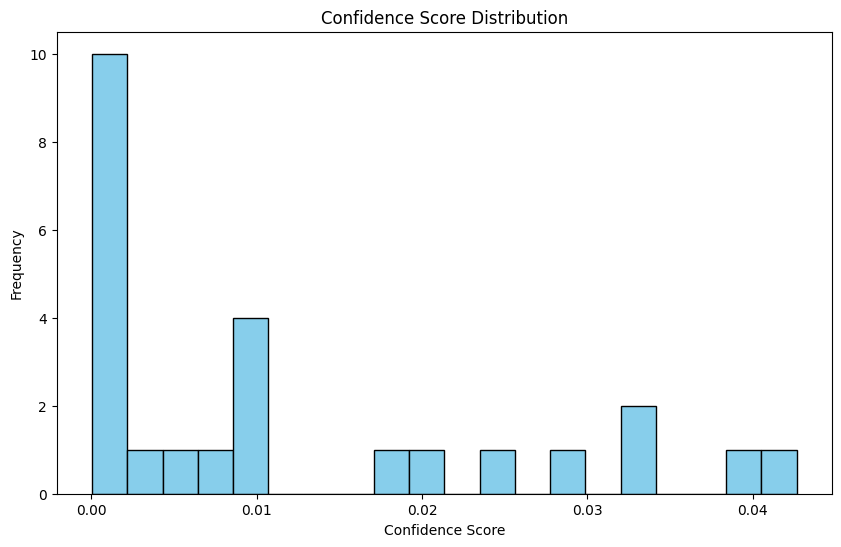

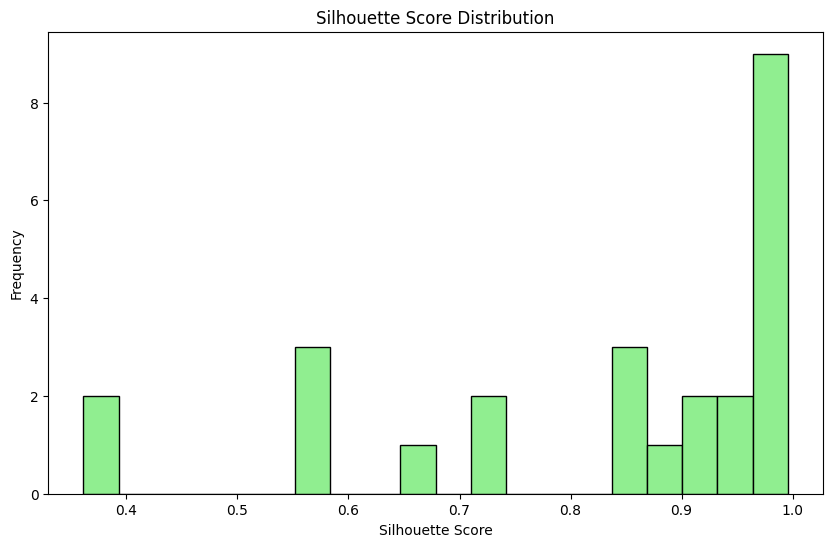

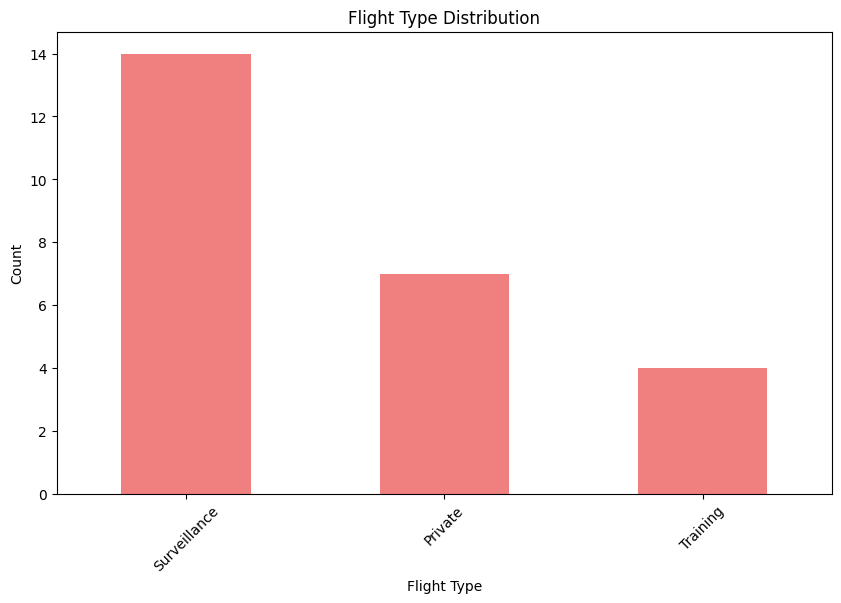


Summary Report:
       Confidence Score Statistics  Silhouette Score Statistics
count                    25.000000                    25.000000
mean                      0.011962                     0.826028
std                       0.013783                     0.200462
min                       0.000042                     0.361291
25%                       0.000553                     0.733166
50%                       0.006739                     0.904332
75%                       0.019246                     0.989859
max                       0.042665                     0.995747


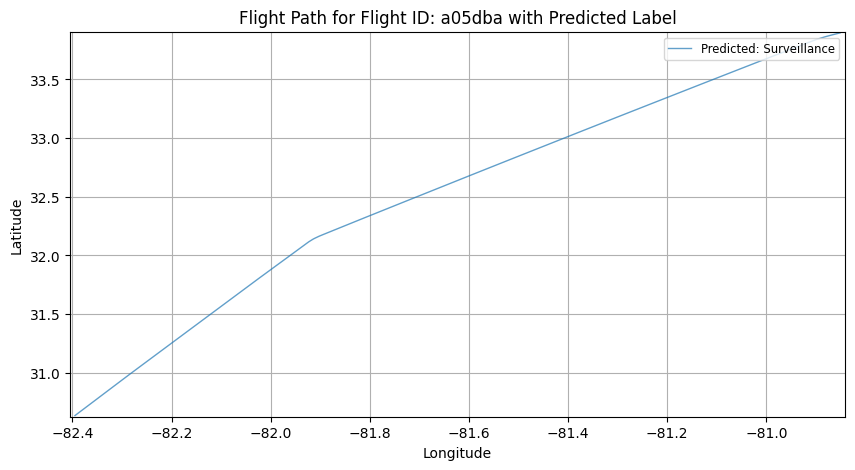

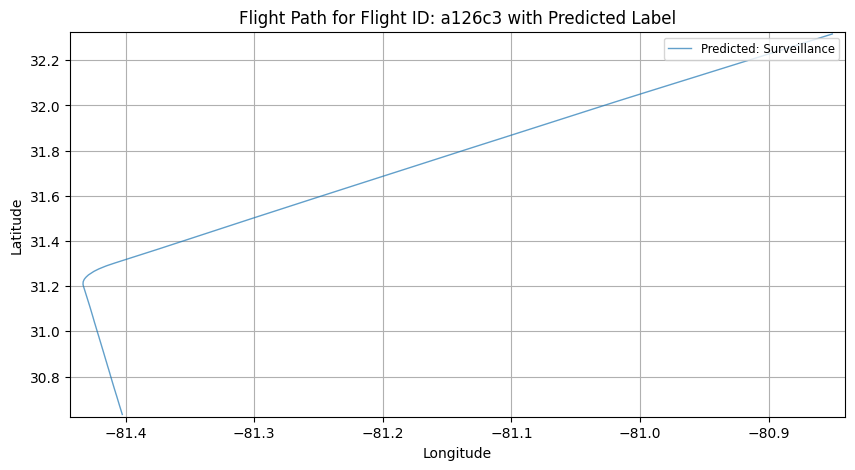

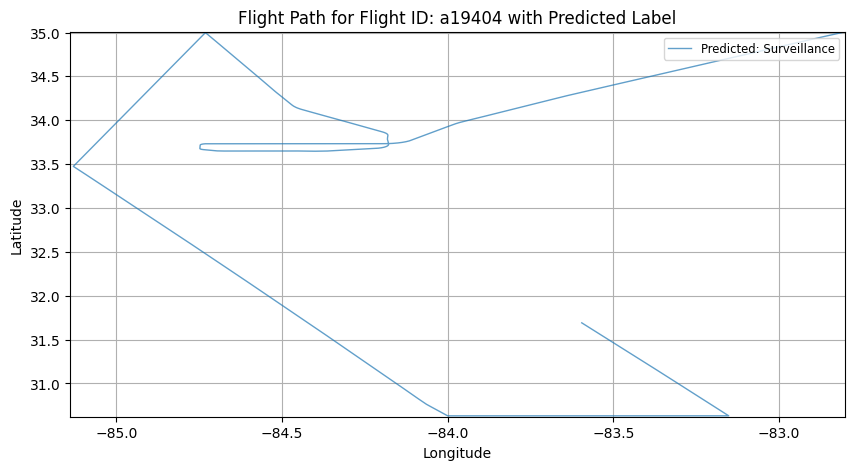

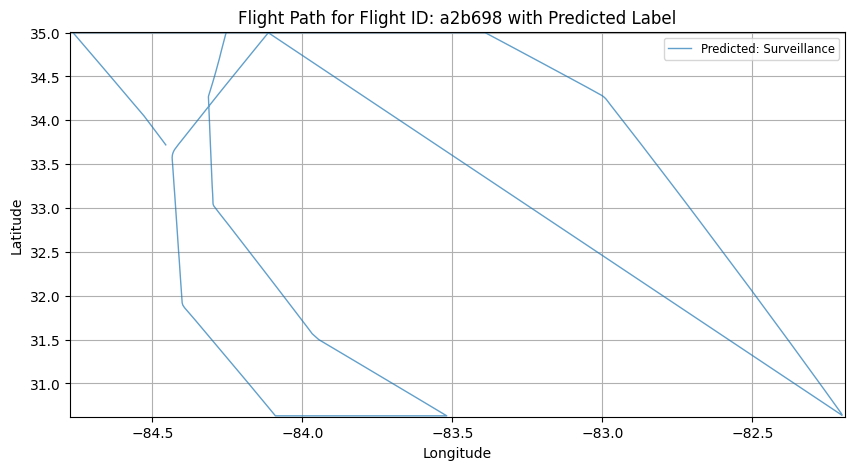

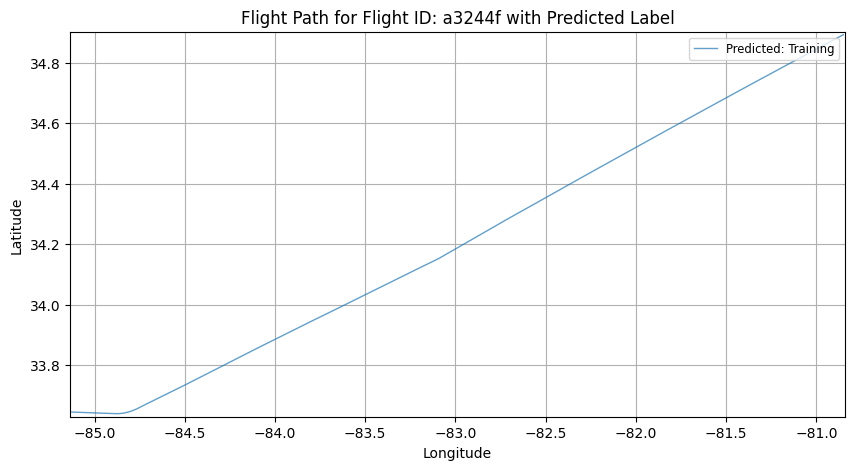

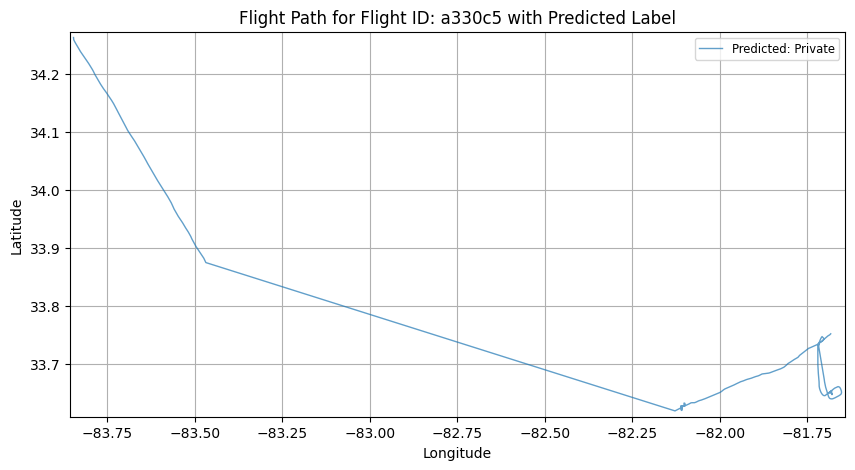

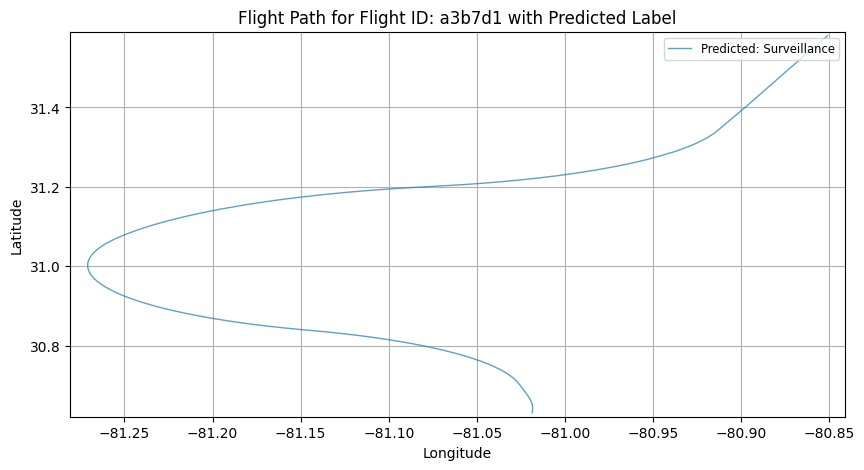

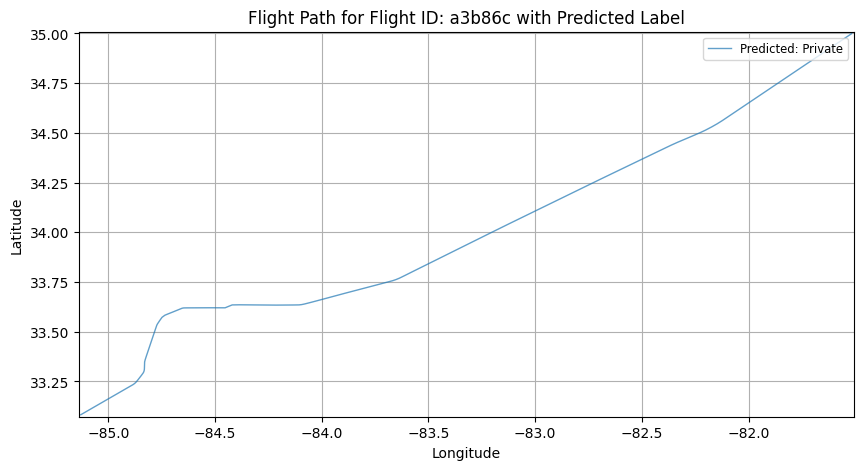

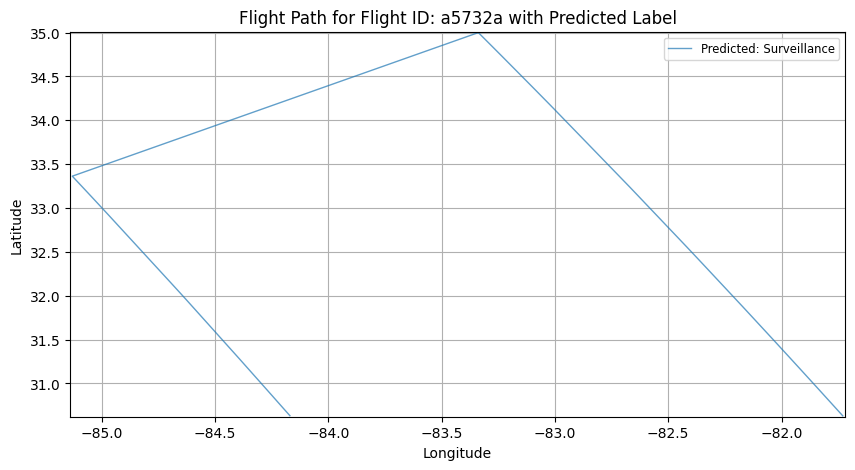

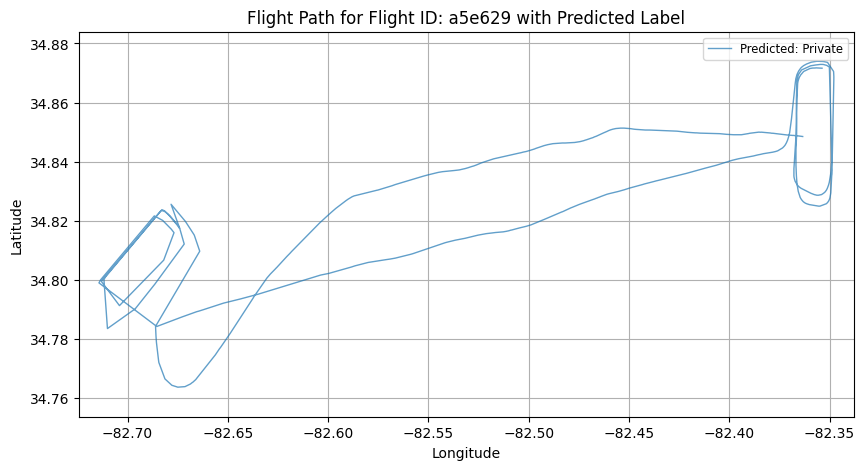

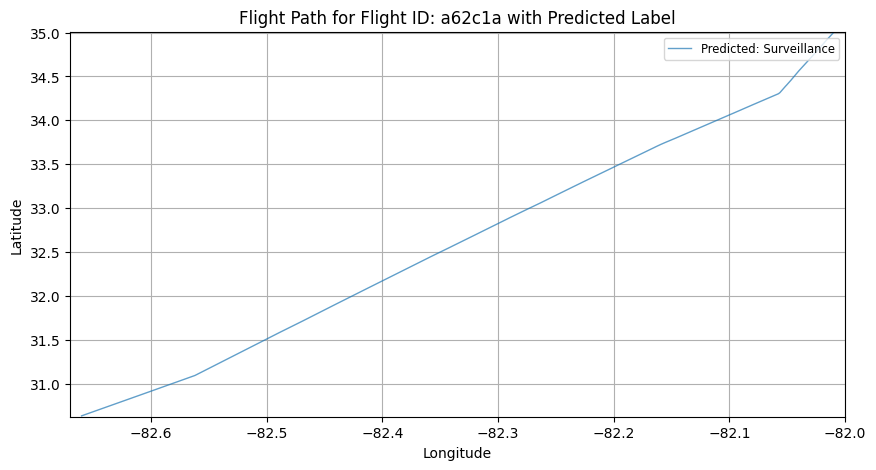

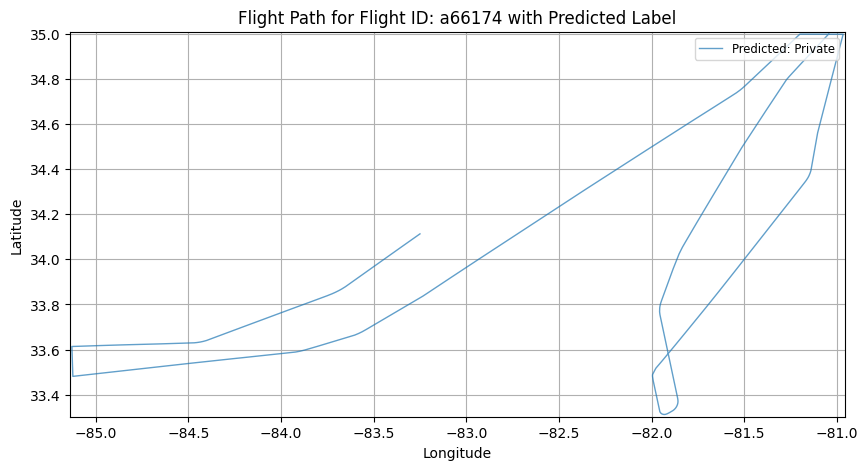

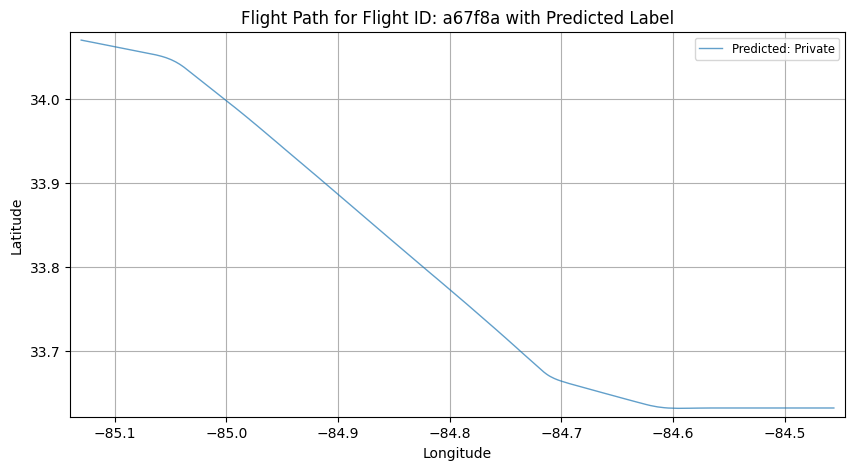

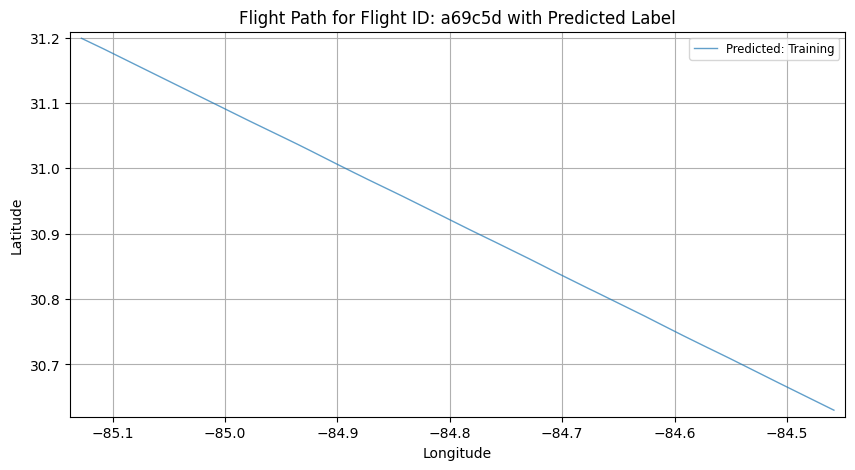

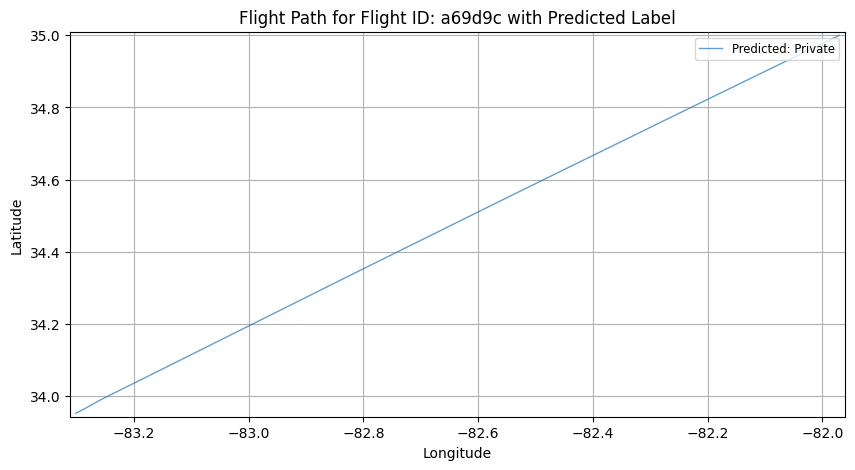

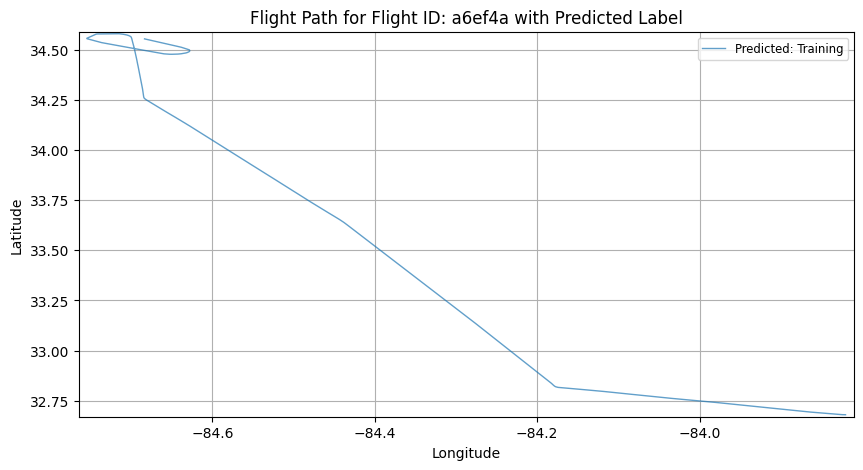

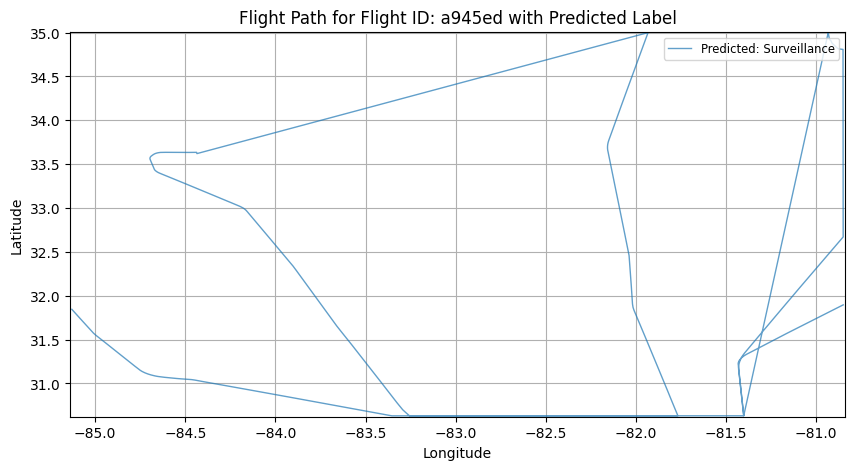

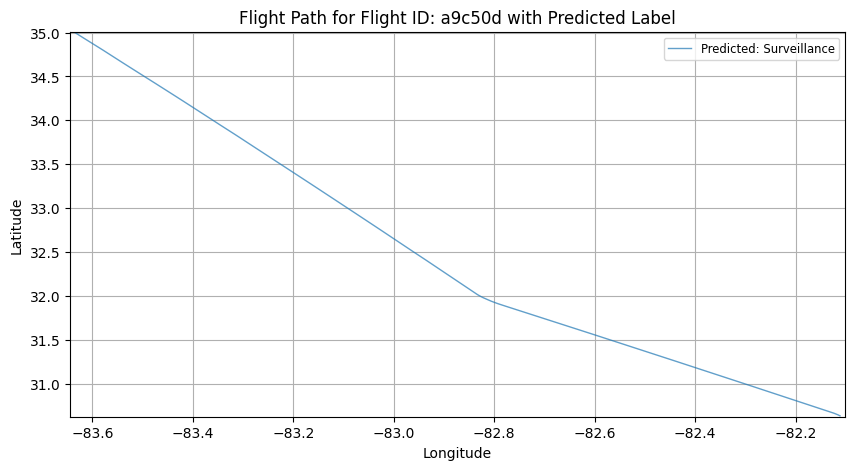

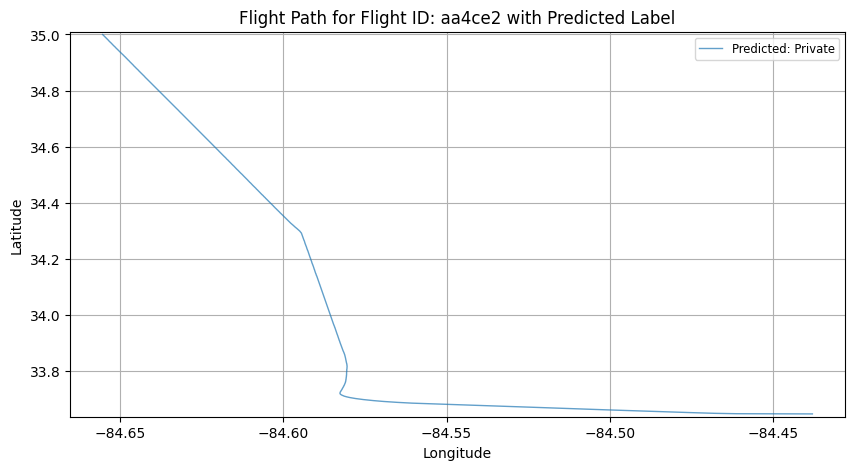

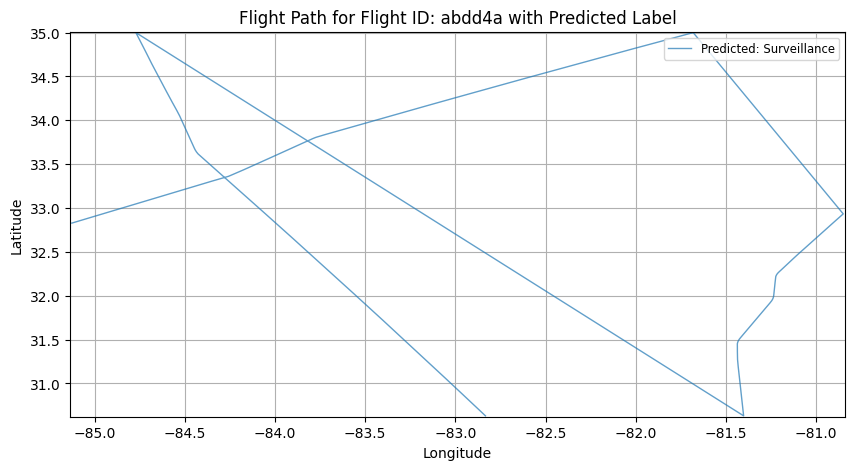

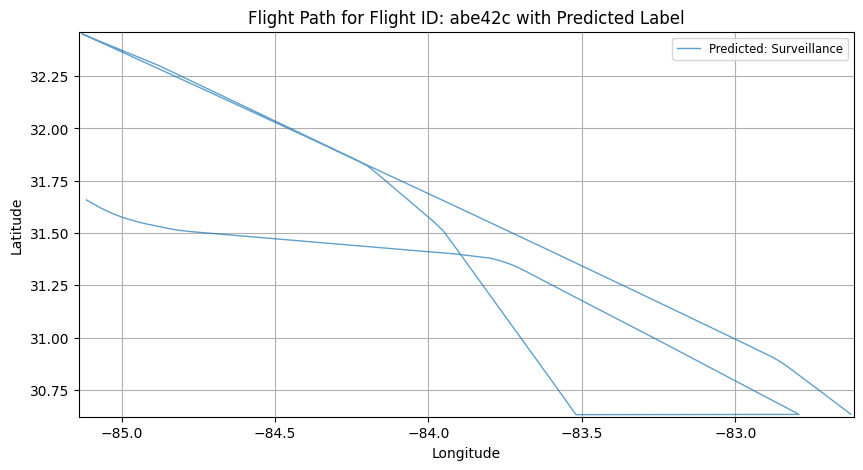

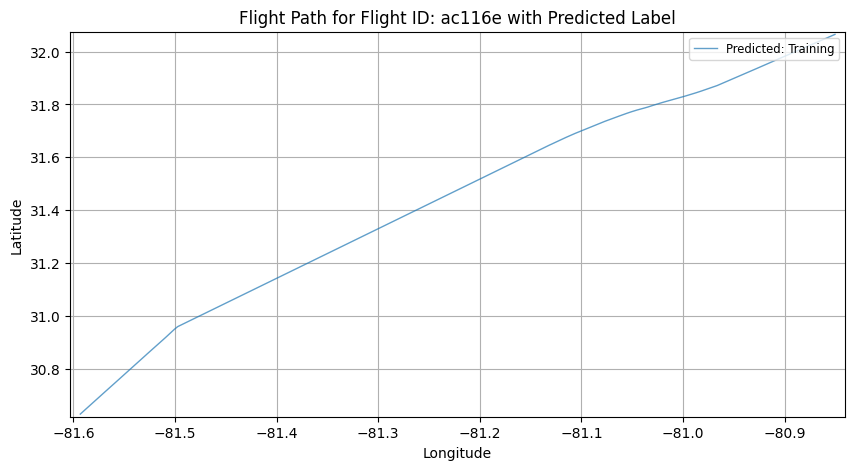

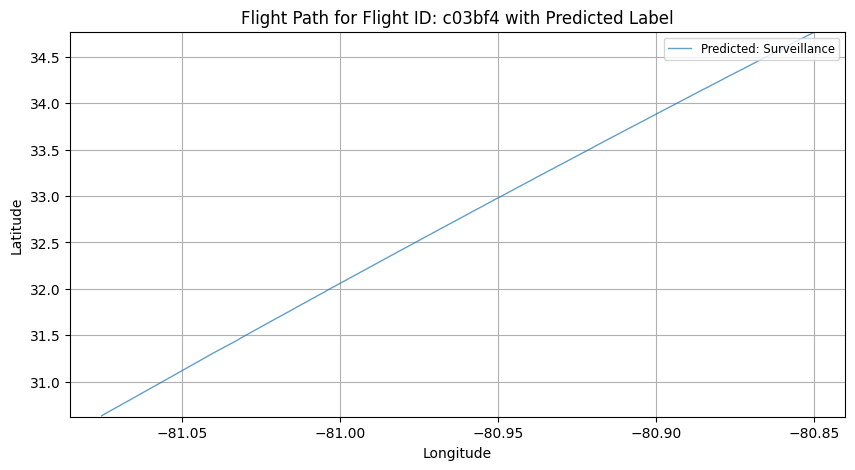

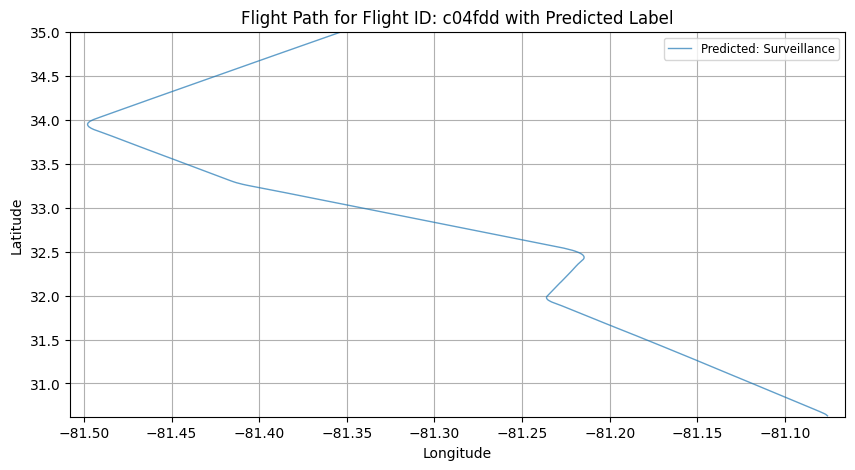

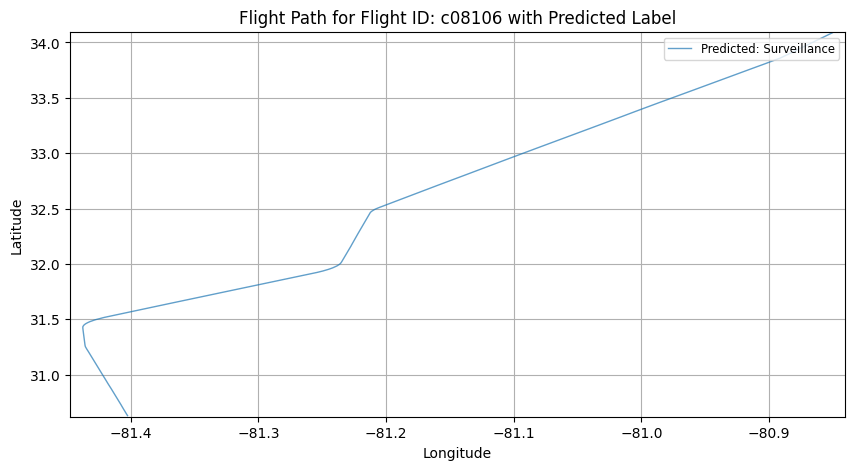

In [13]:
#Unspervised Learning #1 using DTW to label unlabled flight paths by matching paths to 

# Load Flight Data
data = load_open_sky_data()

# Label the flight paths using the 4D distance method
def label_flight_paths(data):
    labels = []
    
    # Iterate over each flight_id and corresponding data
    for flight_id, flight_data in data.groupby('flight_id'):
        
        flight_path = flight_data[['lat', 'long', 'altitude', 'speed']].values.tolist()
        
        # Classify the flight using the DTW-based matching function
        best_match, match_results, confidence_score, silhouette_scores = match_flight_to_prototypes(flight_path)
        
        
        labels.append((flight_id, best_match, match_results, confidence_score, silhouette_scores))
    
    
    return pd.DataFrame(labels, columns=['flight_id', 'label', 'match_results', 'confidence_score', 'silhouette_scores'])

def generate_flight_classification_report(paths, report_filename='flight_classification_report.csv'):
    
    
    # Ensure silhouette_scores are numeric (if not, extract meaningful values)
    if paths['silhouette_scores'].apply(lambda x: isinstance(x, dict)).any():
        # Extract the first value from the dictionary in 'silhouette_scores'
        paths['silhouette_scores'] = paths['silhouette_scores'].apply(lambda x: list(x.values())[0] if isinstance(x, dict) else x)
    
    # Ensure numeric values in silhouette_scores
    paths['silhouette_scores'] = pd.to_numeric(paths['silhouette_scores'], errors='coerce')

    
    label_counts = paths['label'].value_counts()
    

    
    confidence_stats = paths['confidence_score'].describe()
    print("\nConfidence Score Statistics:")
    print(confidence_stats)

    
    silhouette_stats = paths['silhouette_scores'].describe()
    print("\nSilhouette Score Statistics:")
    print(silhouette_stats)

    
    plt.figure(figsize=(10, 6))
    plt.hist(paths['confidence_score'], bins=20, edgecolor='k', color='skyblue')
    plt.title('Confidence Score Distribution')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.show()

    
    plt.figure(figsize=(10, 6))
    plt.hist(paths['silhouette_scores'], bins=20, edgecolor='k', color='lightgreen')
    plt.title('Silhouette Score Distribution')
    plt.xlabel('Silhouette Score')
    plt.ylabel('Frequency')
    plt.show()

    
    plt.figure(figsize=(10, 6))
    label_counts.plot(kind='bar', color='lightcoral')
    plt.title('Flight Type Distribution')
    plt.xlabel('Flight Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

   
    report = {
        'Confidence Score Statistics': confidence_stats,
        'Silhouette Score Statistics': silhouette_stats
    }

    # Create a DataFrame for the report summary
    report_df = pd.DataFrame(report)
    print("\nSummary Report:")
    print(report_df)    


paths = label_flight_paths(data)

data = data.merge(paths[['flight_id', 'label']], on='flight_id', how='left')

generate_flight_classification_report(paths)

plot_flight_paths(data)


Silhouette Score for 5 clusters: 0.2935
Inertia (Confidence Metric) for 5 clusters: 57.0456


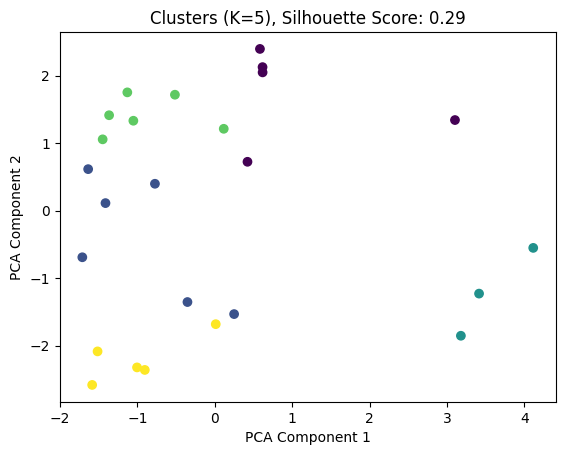

Cluster Centers:
     lat_var  long_var       alt_var    speed_var   avg_speed  avg_altitude  \
0  1.273931  1.098387  1.983214e+06  1057.591082  223.429154  11009.869449   
1  0.125107  0.294214  1.884644e+06   406.332258  203.640033   7839.740925   
2  0.690085  0.969135  1.396048e+07  3410.437691  183.533003   5766.575270   
3  1.349074  0.078589  2.982293e+05    72.738992  229.903495  11517.643810   
4  0.154658  0.193606  1.213073e+06   382.989832   75.833002   1775.392447   

   altitude_range  alternating_changes  
0     4085.077473           543.200000  
1     2879.942491            57.833333  
2    14683.615418           283.000000  
3     3435.860164           132.166667  
4     3227.608966           193.800000  
Cluster 0: {'lat_var': 1.2739307430865079, 'long_var': 1.09838711725022, 'alt_var': 1983213.7173401224, 'speed_var': 1057.5910816392907, 'avg_speed': 223.42915352286886, 'avg_altitude': 11009.869448618745, 'altitude_range': 4085.0774729741775, 'alternating_changes': 

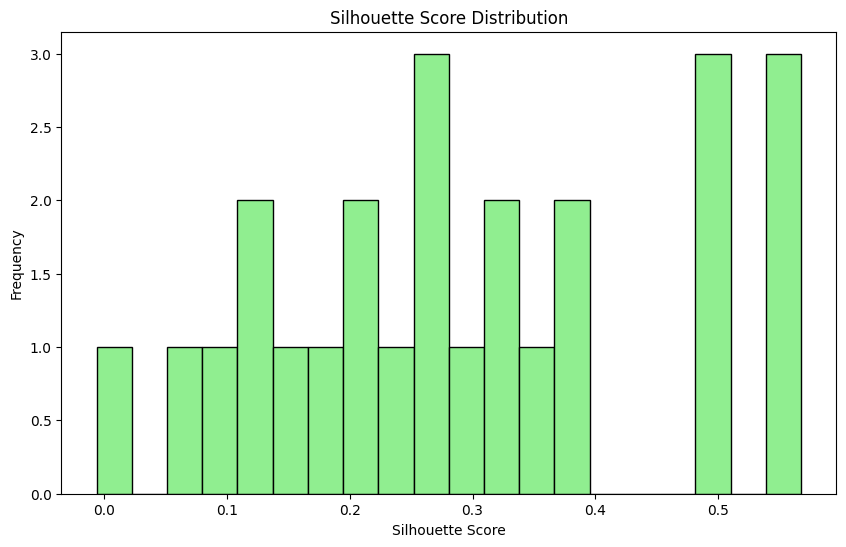

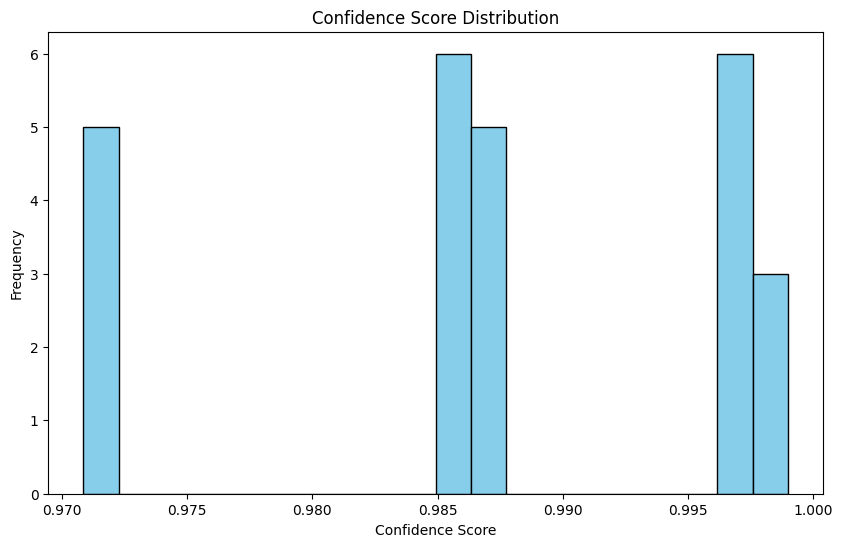

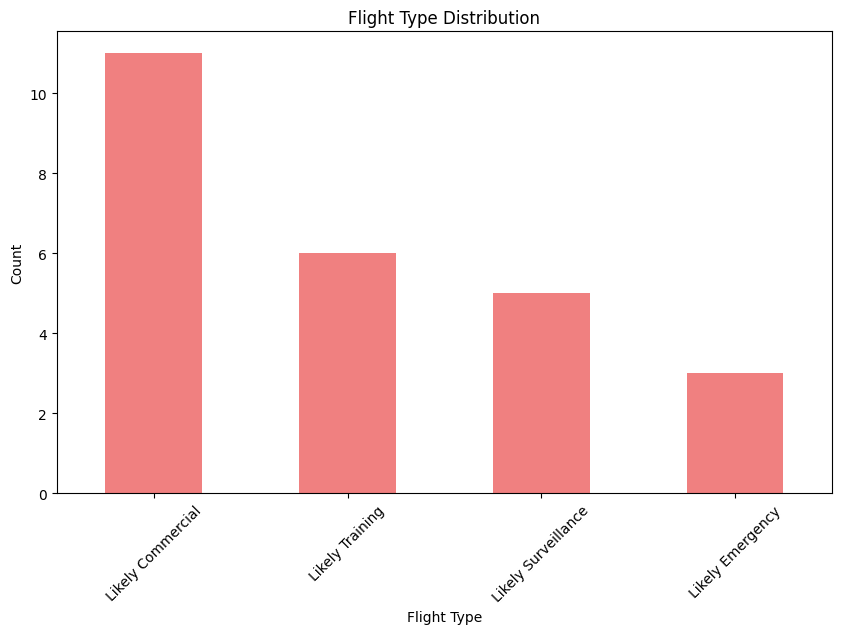


Clustering Metrics:
Overall Silhouette Score: 0.293524358513382
Inertia: 57.04563039714495

Flight Classification Report:
       Confidence Score Statistics  Silhouette Score Statistics
count                 70188.000000                 70188.000000
mean                      0.987218                     0.289347
std                       0.009636                     0.160051
min                       0.970856                    -0.006196
25%                       0.985332                     0.153125
50%                       0.987347                     0.264365
75%                       0.997546                     0.383886
max                       0.998987                     0.567474


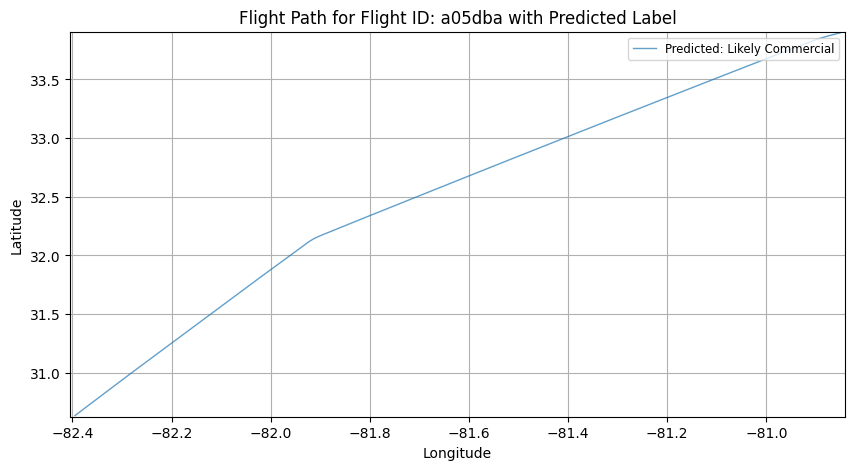

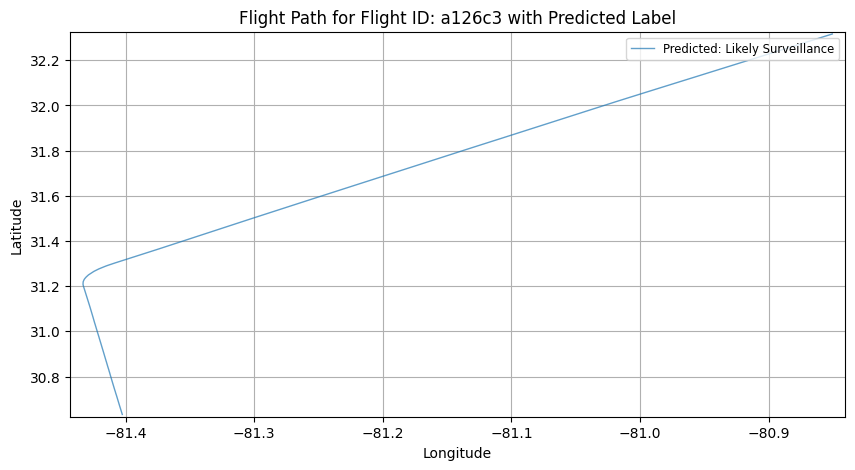

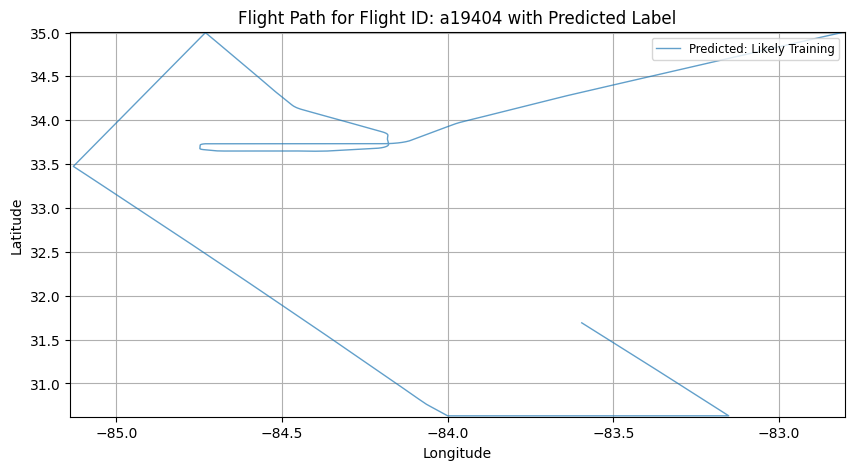

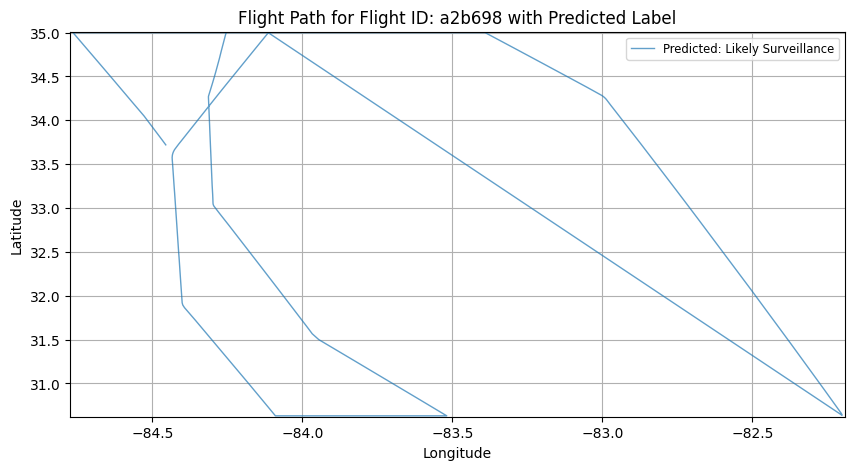

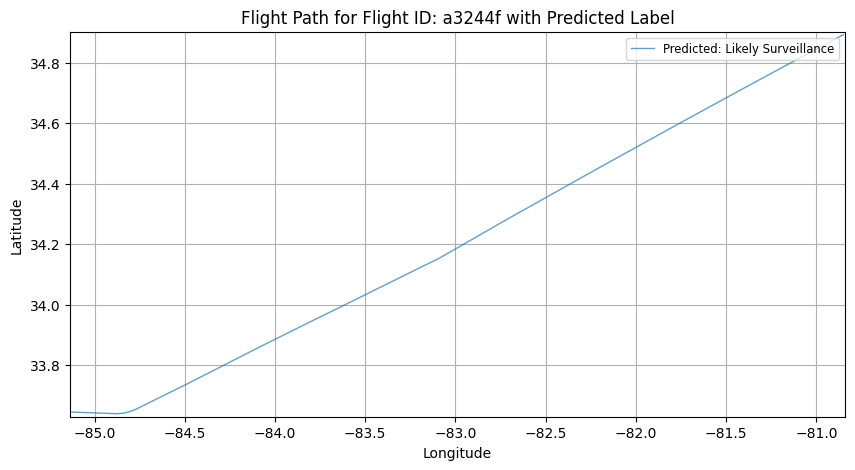

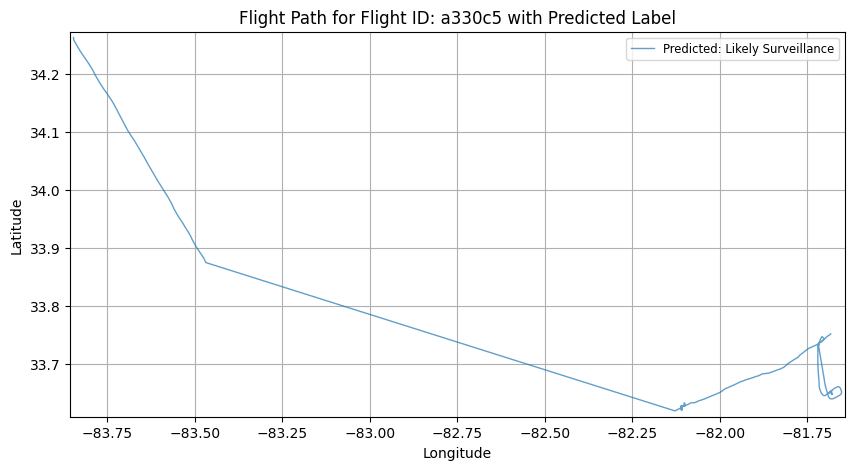

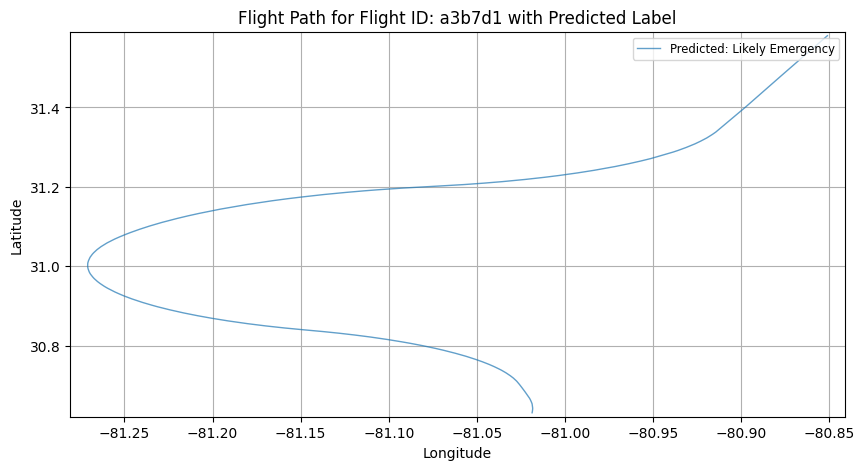

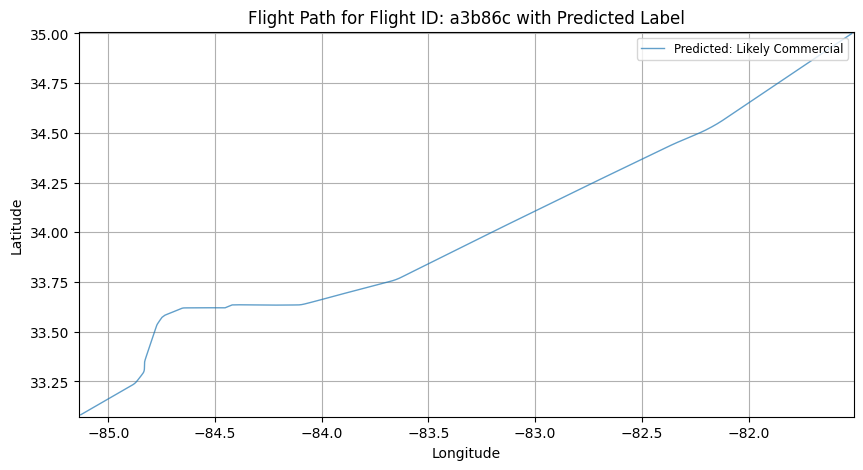

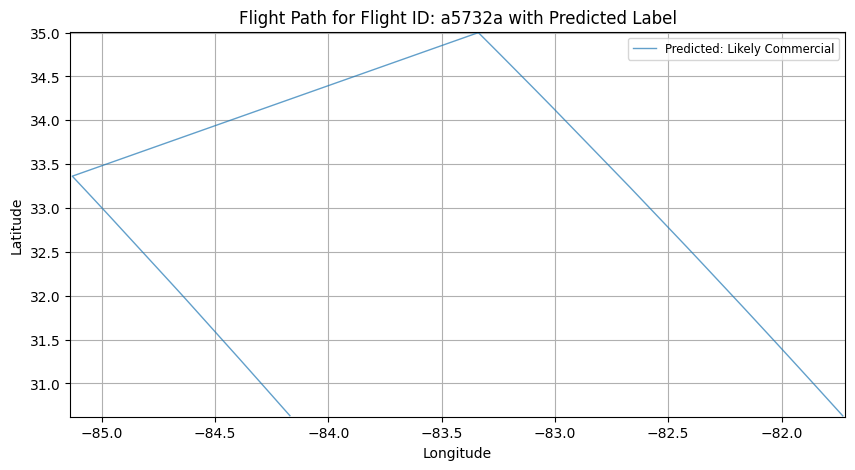

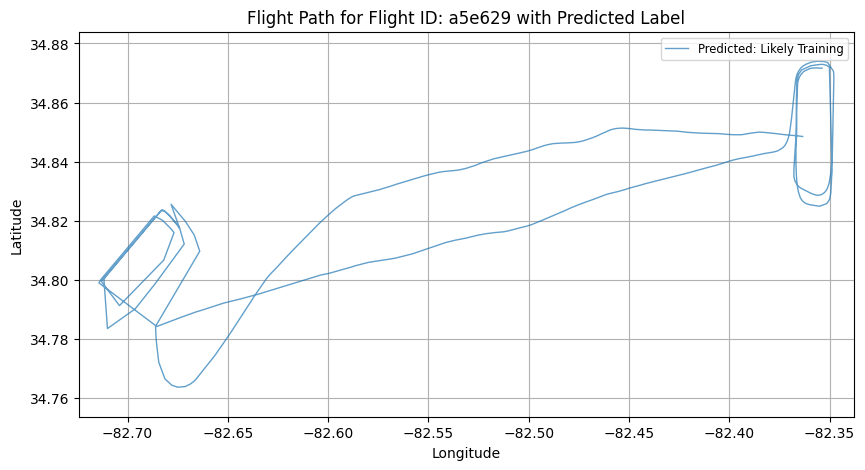

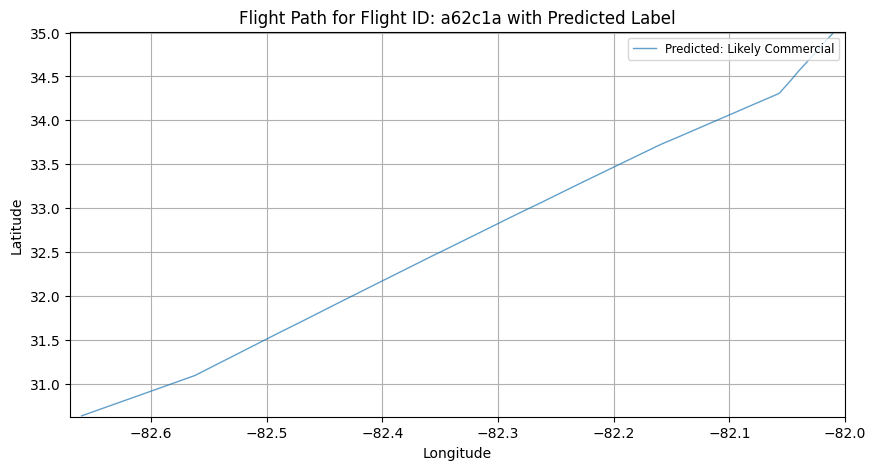

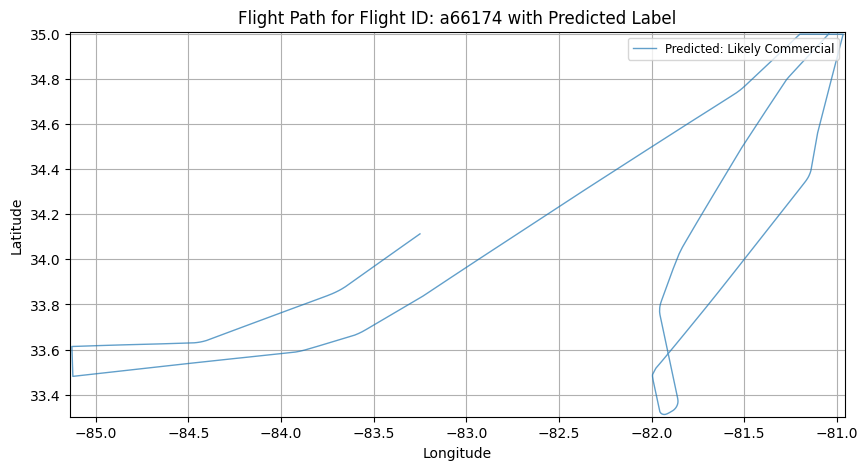

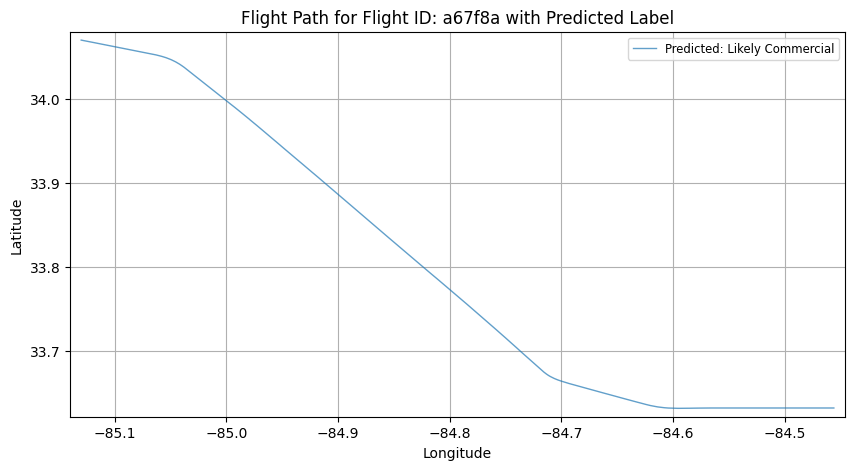

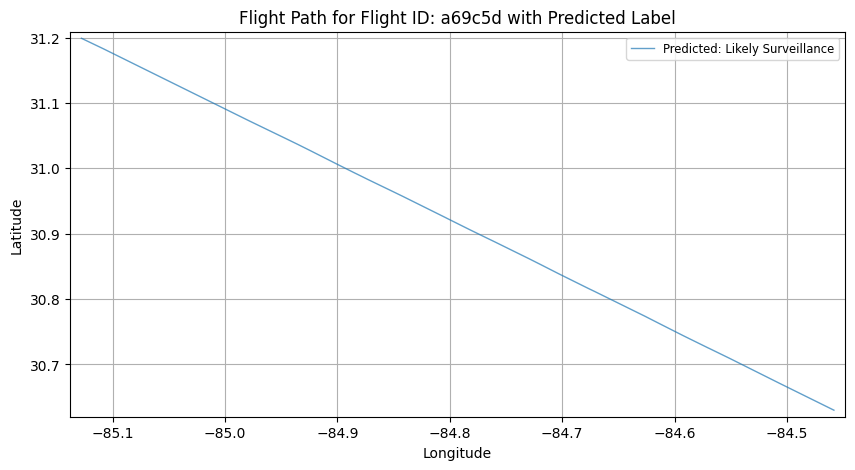

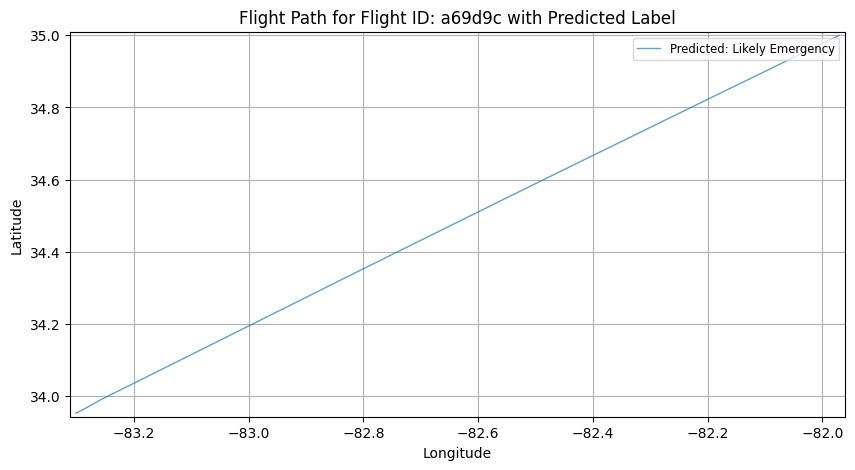

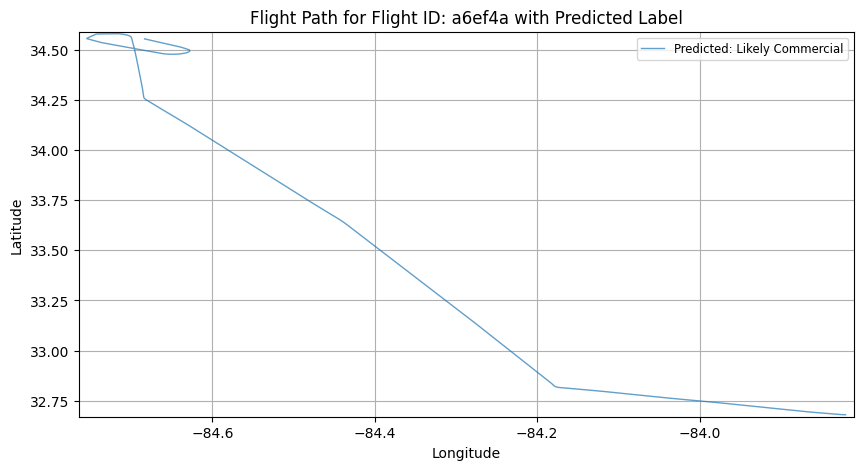

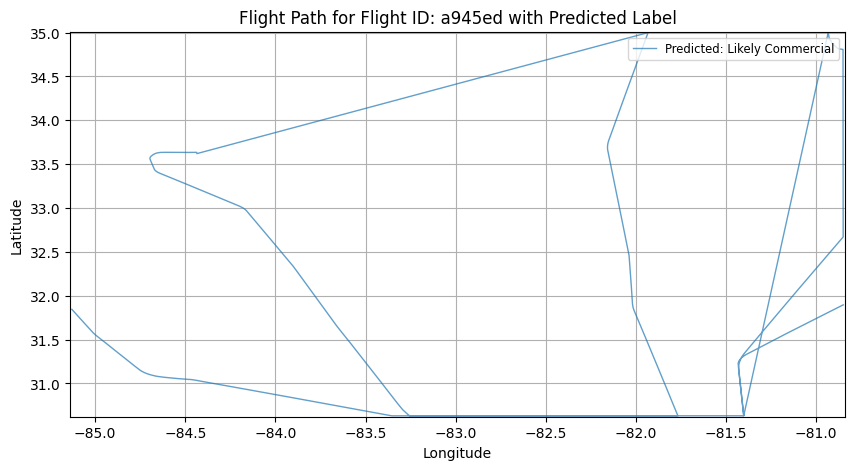

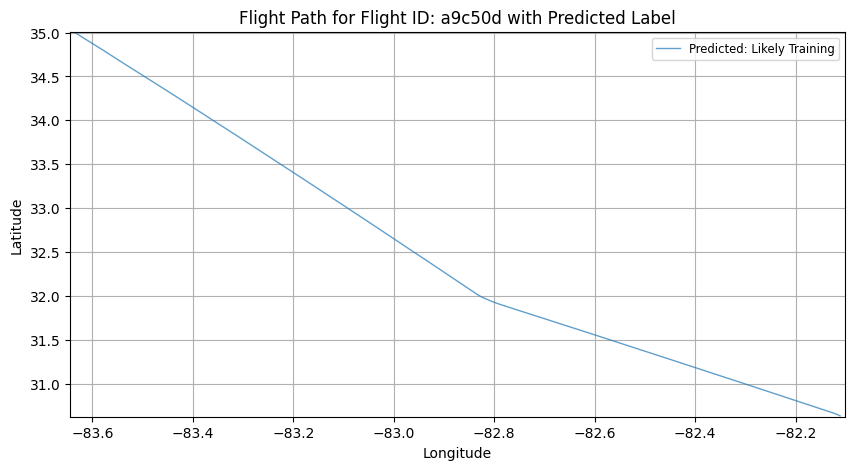

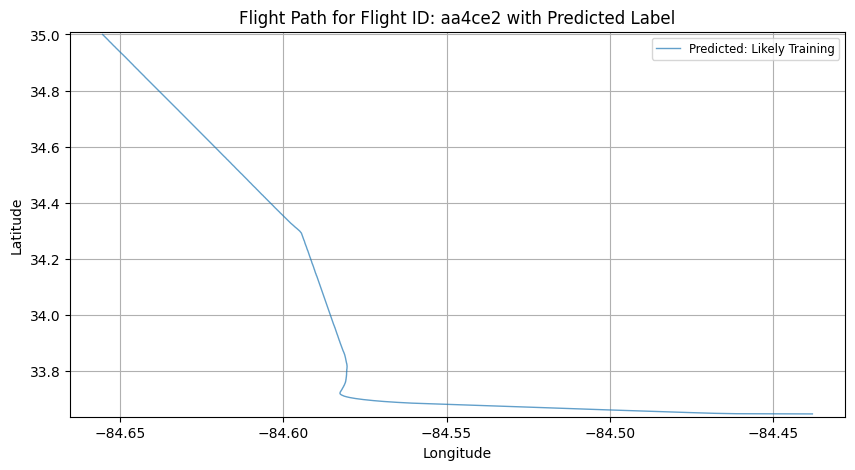

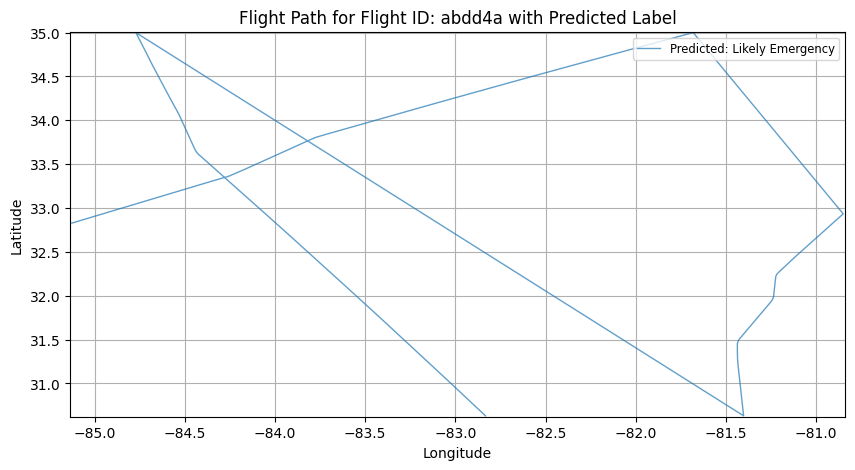

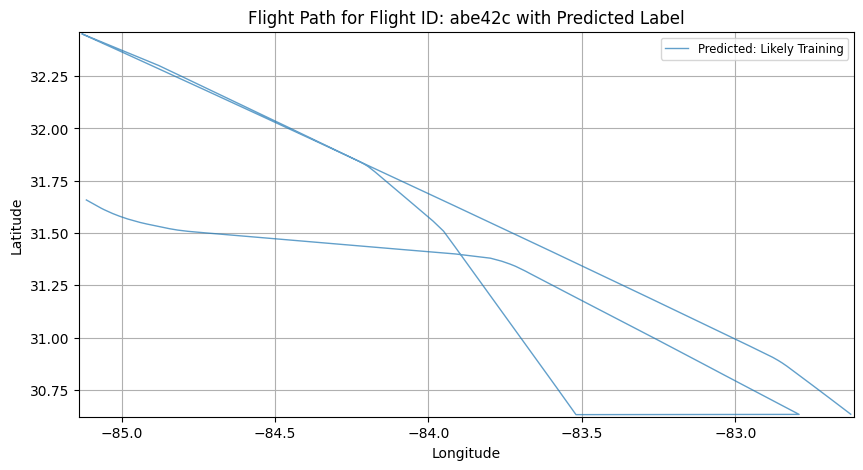

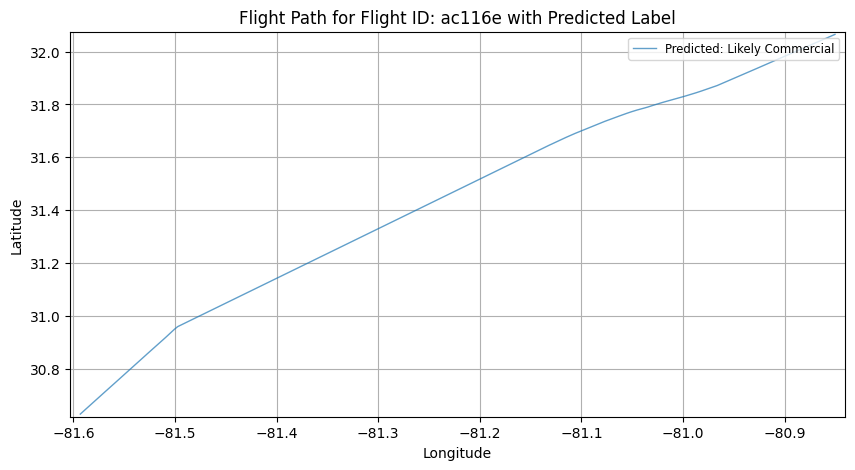

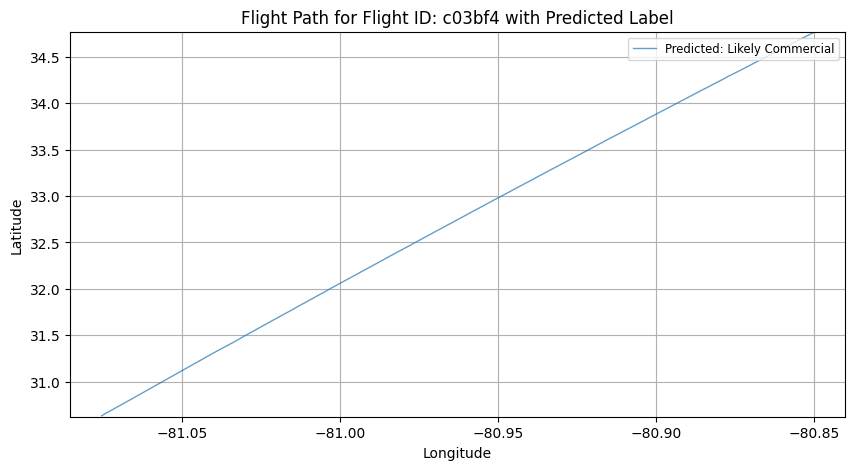

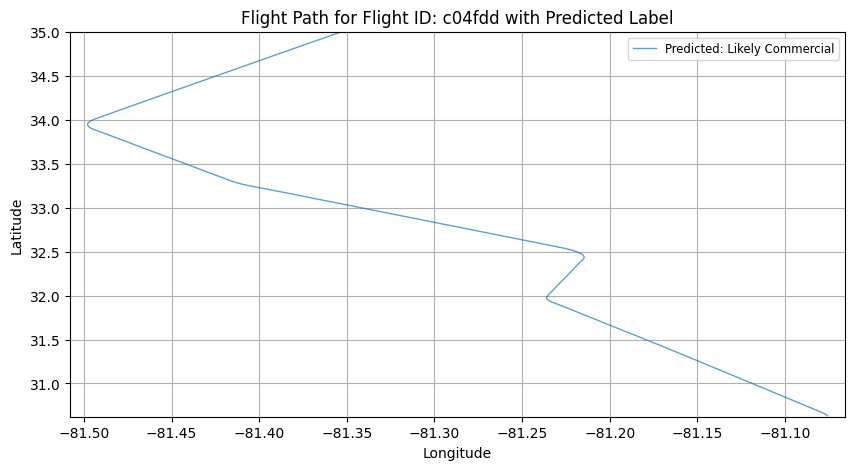

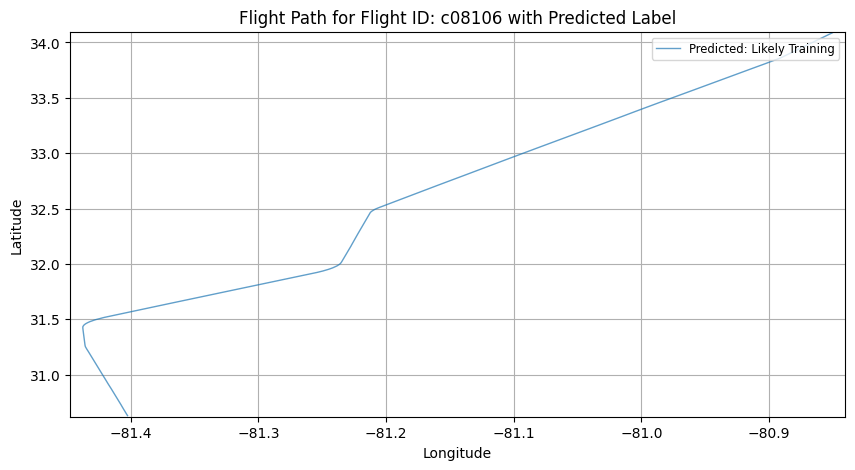

Finished


In [14]:
#unsupervised 2 Pca and Kmeans

data = load_open_sky_data()


def label_flight_paths(data):
    # Apply PCA + K-Means clustering to the entire dataset and get the clustering results
    labels = analyze_flight_data_clustering(data)
    

    # Return the labeled data and metrics for the report
    return labels

data = label_flight_paths(data)

plot_flight_paths(data)

print("Finished")
